# GAN 101
A simple gan model within TensorFlow r1.3 framework. 

## Import

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
% matplotlib notebook

## Load Data Set

In [2]:
dataset_path = os.path.normpath(r"../DataSet/mnist")
mnist_dataset=input_data.read_data_sets(dataset_path, one_hot=True)
print("Number of training samples: {}\nNumber of test samples: {}".format(
        mnist_dataset.train.num_examples, mnist_dataset.test.num_examples))

Extracting ..\DataSet\mnist\train-images-idx3-ubyte.gz
Extracting ..\DataSet\mnist\train-labels-idx1-ubyte.gz
Extracting ..\DataSet\mnist\t10k-images-idx3-ubyte.gz
Extracting ..\DataSet\mnist\t10k-labels-idx1-ubyte.gz
Number of training samples: 55000
Number of test samples: 10000


## Define model
### Remarks
#### Initialize the variables with caution
In the two loss function defined below, singulars will occur in case the output of the network contains $1$ or $0$, given that the loss function contains the term $\log(x)$ or $\log(1-x)$. In our case the output layer of both generator and discriminator network contains a simgoid function. In $y=sigmoid(wx+b)$, if the weights are too large then the result of this term quickly approaches $0$ or $1$ as $x$ moves away from $0$. Hence the mean and stddev of weight distribution at the output layer are set to $0$ a relatively small value, respectively, to opt out the occurence of singulars in loss functions.  

In [3]:
class GAN:
    def __init__(self, noise_input_tensor, image_input_tensor, generator_hidden_dim, discriminator_hidden_dim):
        self._noise_input = noise_input_tensor
        self._image_input = image_input_tensor
        with tf.variable_scope("generator"):
            self._generator_output, self._generator_parameters = self._fnn(
                noise_input_tensor, generator_hidden_dim, image_input_tensor.shape[1])
        with tf.variable_scope("discriminator"):
            self._discriminator_output_for_real_data, self._discriminator_parameters = self._fnn(
                image_input_tensor, discriminator_hidden_dim, 1)
        with tf.variable_scope("discriminator", reuse=True):  # Share weights and biases
            d_o_fake = self._discriminator_output_for_synth, _ = self._fnn(self._generator_output, discriminator_hidden_dim, 1)
        
    def _fnn(self, input_tensor, hidden_dim, output_dim):
        w_xh = tf.get_variable(initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01),
                            shape=[input_tensor.shape[1], hidden_dim], name="W_xh")
        b_xh = tf.get_variable(initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01),
                            shape=[hidden_dim], name="b_xh")
        hidden = tf.nn.relu(tf.add(tf.matmul(input_tensor, w_xh), b_xh))
        w_ho = tf.get_variable(initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01), 
                            shape=[hidden_dim, output_dim], name="W_ho")
        b_ho = tf.get_variable(initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01), 
                            shape=[output_dim], name="b_ho")
        output = tf.add(tf.matmul(hidden, w_ho), b_ho)
        return tf.sigmoid(output), [w_xh, b_xh, w_ho, b_ho]
        
        
    @property
    def noise_input(self):
        return self._noise_input
    
    @property
    def image_input(self):
        return self._image_input
    
    @property
    def generator_output(self):
        return self._generator_output

    @property
    def discriminator_output_from_generator(self):
        return self._discriminator_output_for_synth
    
    @property
    def discriminator_output_from_image_input(self):
        return self._discriminator_output_for_real_data
    
    @property
    def g_param(self):
        return self._generator_parameters[:]
    
    @property
    def d_param(self):
        return self._discriminator_parameters[:]

## Specify Dimensions

In [4]:
noise_dim = 128
image_dim = 28*28
generator_hidden_dim = 256
discriminator_hidden_dim = 256

## Create GAN model, define I/O , loss functions and optimizers. 
### Remarks
#### Specifiy the variables to be trained
By default in TensorFlow, all variables are updated by each optimizer, so we need to specify the variables to be trained for each one of the optimizer. In this case we have two optimizers for improving the performance of the generator network and discriminator network, respectively. 

In [5]:
tf.reset_default_graph()
generator_input = tf.placeholder(shape=[None, noise_dim], dtype=tf.float32)
discriminator_input = tf.placeholder(shape=[None, image_dim], dtype=tf.float32)
gan = GAN(generator_input, discriminator_input, generator_hidden_dim, discriminator_hidden_dim)
generator_loss = -tf.reduce_mean(tf.log(gan.discriminator_output_from_generator))
discriminator_loss = -tf.reduce_mean(
    tf.log(gan.discriminator_output_from_image_input)+tf.log(1.0-gan.discriminator_output_from_generator))
g_train_op = tf.train.AdamOptimizer(learning_rate=2e-4).minimize(generator_loss, var_list=gan.g_param)
d_train_op = tf.train.AdamOptimizer(learning_rate=2e-4).minimize(discriminator_loss, var_list=gan.d_param)

## Start Training

In [6]:
n_epoch = 100
batch_size = 50
num_batch = int(mnist_dataset.train.num_examples/batch_size)
visualize_every = 2
k = 1
model_param_path = os.path.normpath(r"./model_checkpoints")
saver=tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epoch):
        for batch_no in range(num_batch):
            image_batch, _ = mnist_dataset.train.next_batch(batch_size) # discard the labels
            # Train the discriminator network k times
            for _ in range(k):
                noise_batch = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])
                feed_dict = {gan.image_input: image_batch, gan.noise_input: noise_batch}
                sess.run(d_train_op, feed_dict=feed_dict)
            # Train the generator network once
            noise_batch = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])
            feed_dict = {gan.image_input: image_batch, gan.noise_input: noise_batch}
            _, g_loss, d_loss = sess.run([g_train_op, generator_loss, discriminator_loss], feed_dict=feed_dict)
        if (epoch % visualize_every) == 0:
            print("Epoch {}:\nGenerator loss:\n{}\nDiscriminator loss:\n{}".format(epoch, g_loss, d_loss))
    saver.save(sess=sess,save_path=os.path.join(model_param_path, "GAN"))
    print("Done!")

Epoch 0:
Generator loss:
2.2923636436462402
Discriminator loss:
0.30184563994407654
Epoch 2:
Generator loss:
2.844787836074829
Discriminator loss:
0.2506345510482788
Epoch 4:
Generator loss:
3.1854028701782227
Discriminator loss:
0.19682487845420837
Epoch 6:
Generator loss:
3.656008243560791
Discriminator loss:
0.1103038489818573
Epoch 8:
Generator loss:
3.115192174911499
Discriminator loss:
0.22244034707546234
Epoch 10:
Generator loss:
3.0198018550872803
Discriminator loss:
0.30496856570243835
Epoch 12:
Generator loss:
2.9965620040893555
Discriminator loss:
0.2170773446559906
Epoch 14:
Generator loss:
3.7963035106658936
Discriminator loss:
0.2221698760986328
Epoch 16:
Generator loss:
4.117164611816406
Discriminator loss:
0.1404392123222351
Epoch 18:
Generator loss:
3.7899703979492188
Discriminator loss:
0.15159901976585388
Epoch 20:
Generator loss:
3.198230266571045
Discriminator loss:
0.4755263924598694
Epoch 22:
Generator loss:
3.5346813201904297
Discriminator loss:
0.22175830602645

## Test Network

INFO:tensorflow:Restoring parameters from model_checkpoints\GAN


<IPython.core.display.Javascript object>


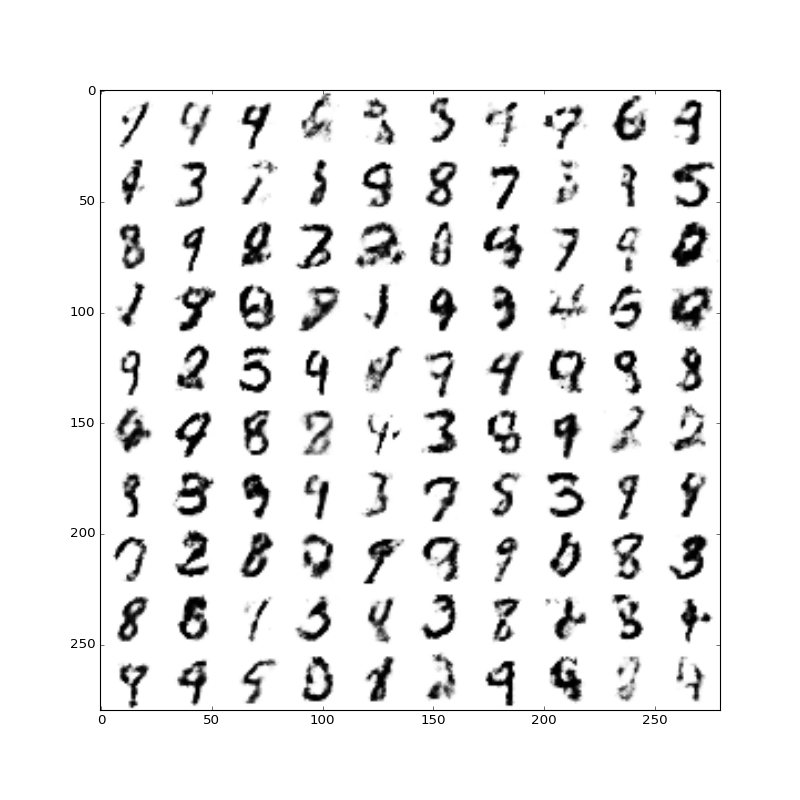

In [7]:
n = 10
canvas = np.empty((28 * n, 28 * n))
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(model_param_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        for i in range(n):
            # Noise input.
            z = np.random.uniform(-1., 1., size=[n, noise_dim])
            # Generate image from noise.
            g = sess.run(gan.generator_output, feed_dict={gan.noise_input: z})
            # Reverse colours for better display
            g = -1 * (g - 1)
            for j in range(n):
                # Draw the generated digits
                canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])
        plt.figure(figsize=(n, n))
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.show()
    else:
        print("Failed to load model checkpoint.")